In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import randint

import seaborn as sns

from xgboost import XGBClassifier, plot_importance

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

from sklearn import preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_curve, f1_score, accuracy_score

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import warnings

import shap

from ydata_profiling import ProfileReport

/home/ilya/workspace/jupyter/venv_jupyter_310/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/home/ilya/workspace/jupyter/venv_jupyter_310/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
warnings.filterwarnings("ignore")

In [3]:
plt.rcParams["figure.figsize"] = (14, 7)

### Первое знакомство с данными
* Просмотреть первые 5 значений
* Обратить внимание на колонки, значения, тип данных
* Сделать первые предположения о данных

In [4]:
credit_cards = pd.read_csv('creditcard_2023.csv')
credit_cards.head(5)

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


### Количество записей

In [5]:
credit_cards.shape[0]

568630

## Первый взгляд 
* Колонка с id нам не понадобится
* Имена колонок обезличены. Это исключает какую-то предвзятость в выборе
* Проверить на пропущенные значение
* Целевое значение представлено полем Class: (1 - fraud) , (0 - no fraud)

#### Предположения
* Class=1 операций должно быть меньше, чем Class=0. Скорее всего в реальном мире мошенических транзакций меньше, чем обычных.

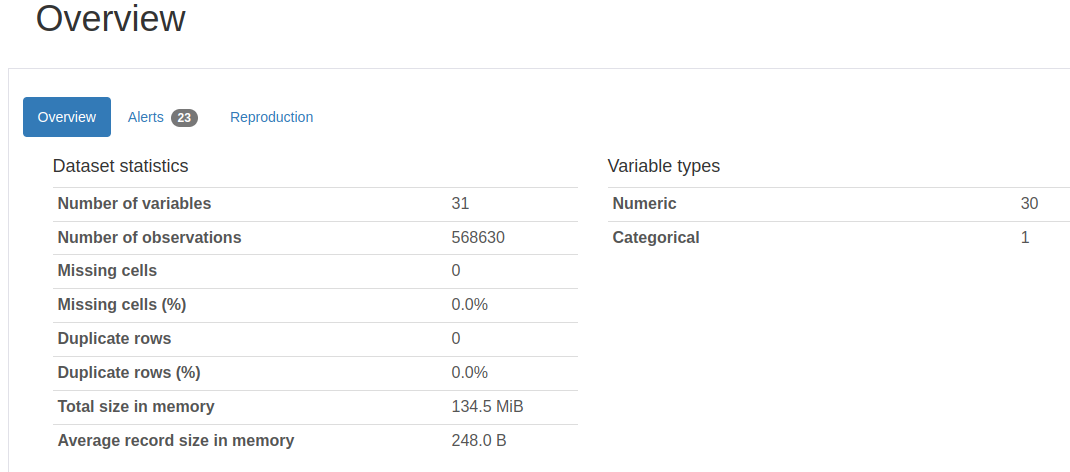

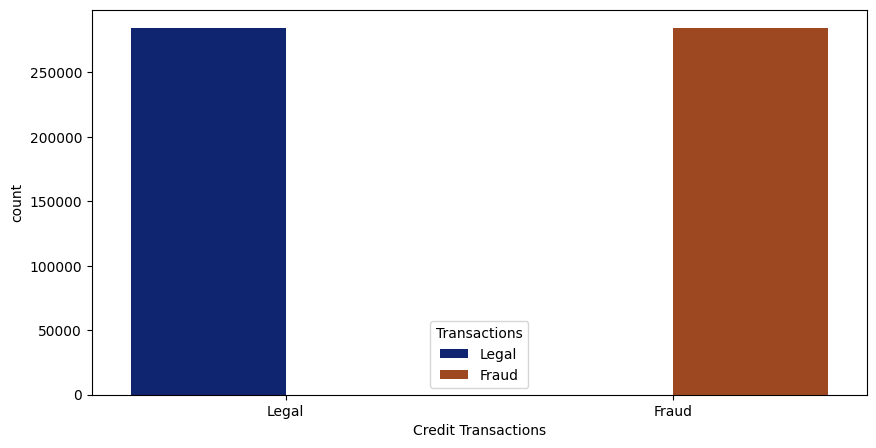

In [6]:
# Проверка данных на смещение (сравнение количества операций Fraud | No fraud)
plt.figure(figsize=(10,5))
chart = sns.countplot(data=credit_cards, x='Class', hue='Class', palette='dark')
chart.set(xlabel='Credit Transactions', xticks=[0,1], xticklabels=('Legal', 'Fraud'))
chart.legend(title='Transactions', labels=['Legal', 'Fraud'])
plt.show()

#### **Вывод:** 
##### Данные не смещены, что хорошо* для построение моделей. Датасет сбалансирован.
*Потому что когда датасет смещен (например 90/10), то модель вида y=1 будет иметь точность (accuracy 90%)
* не работают некоторые метрики

#### What's next?
* Уберем ненужную колонку ID
* Посмотрим на хитмап данных с целью посмотреть какие есть взаимосвязи в данных.

In [7]:
# Убрали колонку ID
df = credit_cards[credit_cards.columns[1:]]

In [8]:
# Свапнуть классы, т.к. более понятно, когда 1 - это хорошо (True, обычная операция) и 0 - плохо (False, fraud)

df['Class'].replace({1:0, 0:1}, inplace=True)

#### Heat map

* Пересечение в таблице - значение кореляции двух соответствующих столбцу и колонке признаков
* Справа можно видеть шкалу. 
    * Чем светлее (ближе к 1) тем сильнее корреляция (положительная корреляция).
    * Чем темнее (ближе к -1) тем сильнее отрицательная корреляция.
    * Если ближе к 0 или в окрестностях 0, то корреляция слабая или почти отсутствует.

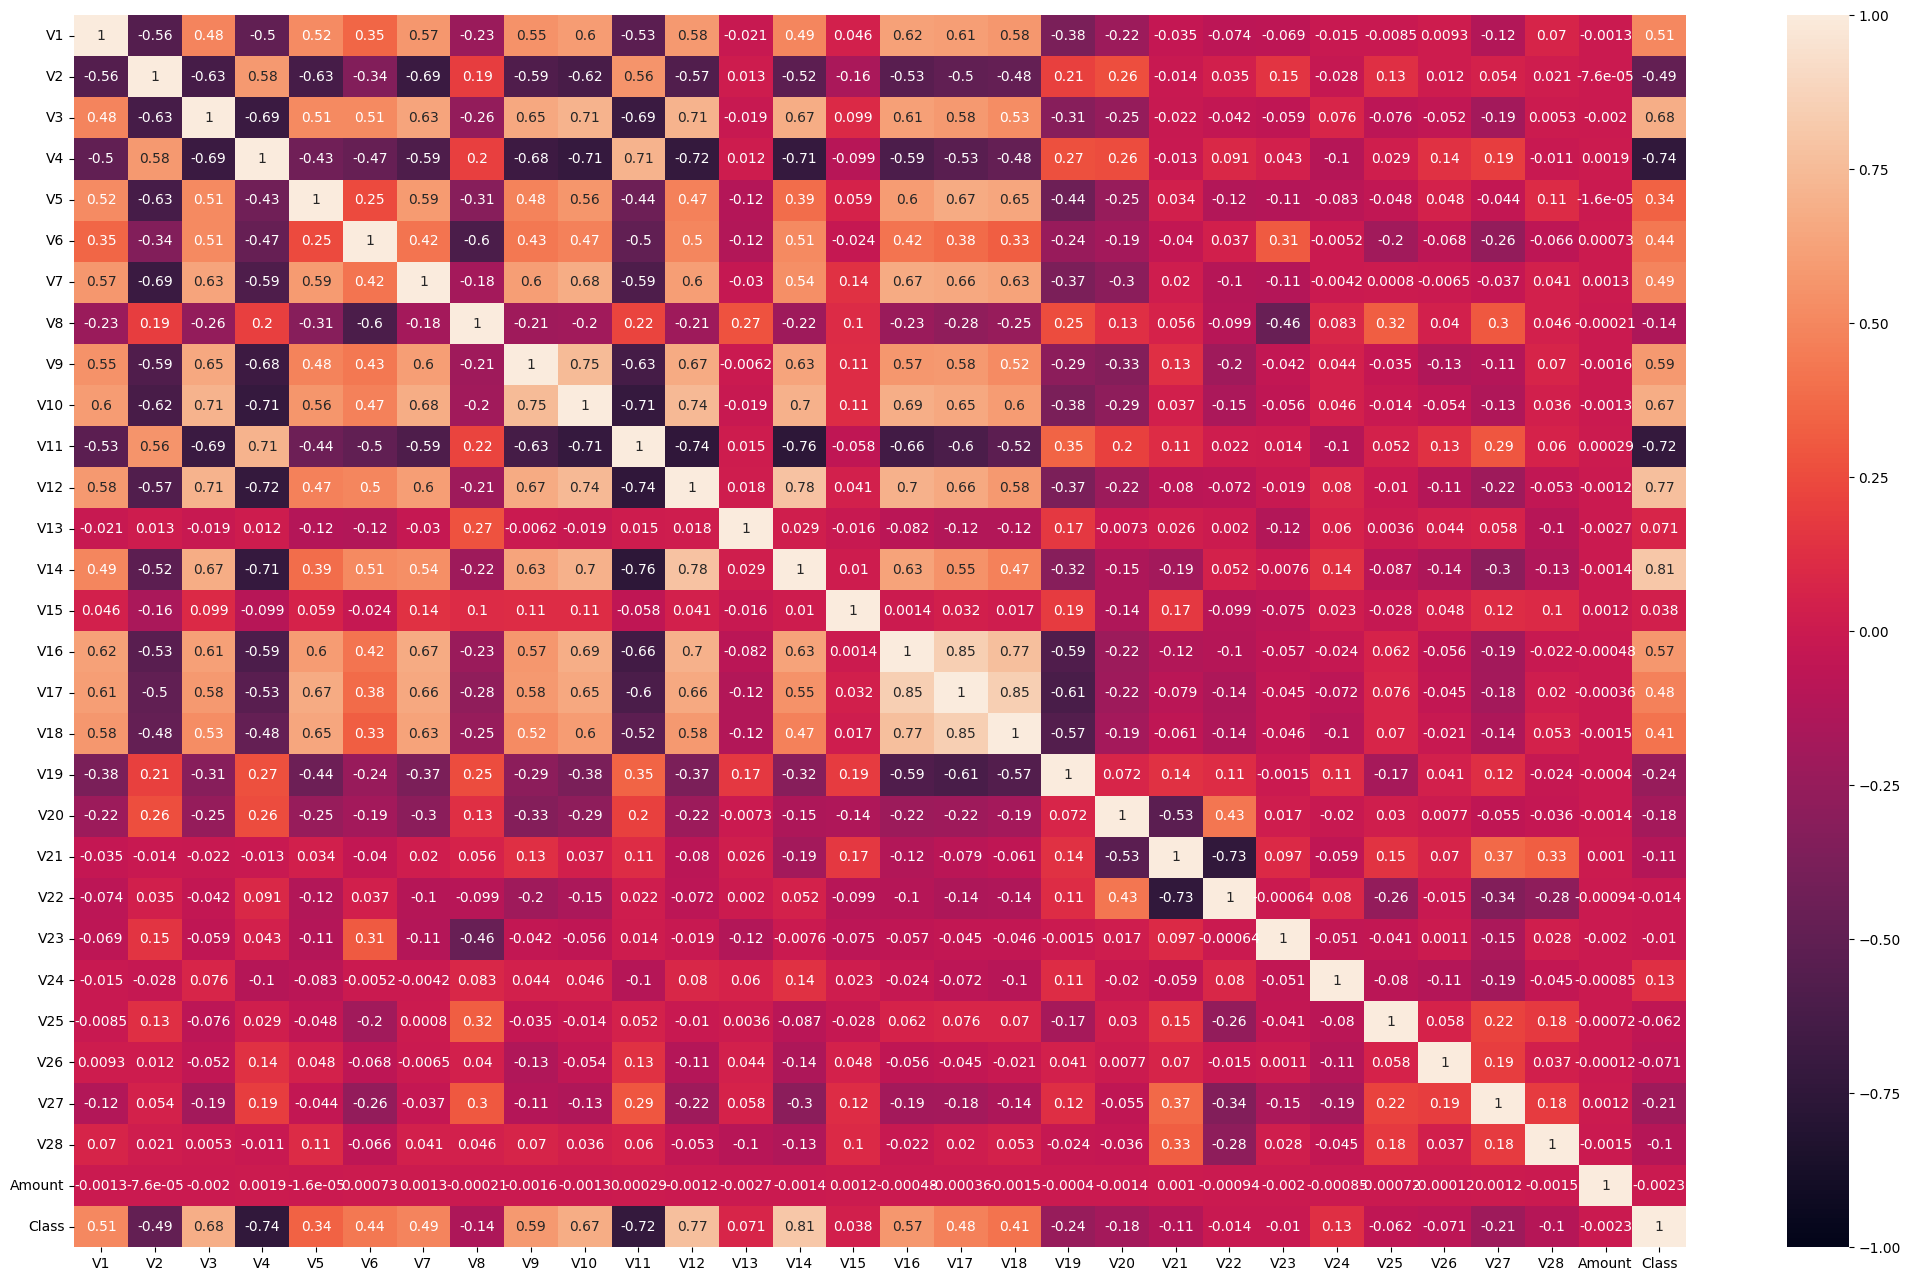

In [9]:
plt.figure(figsize=(26, 16))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

### Наблюдения
* V1-V18 наблюдается попарная корреляция признаков (кроме v13 и v15)
* V1-V12, V14, V16-V21, V27 корреляция с целевым значением 

### Распределение значений (boxplot) каждой фичи (V1-V28)

In [10]:
df_boxplot = pd.DataFrame(data=df, columns=df.columns[:-2])
plt.figure(figsize=(26, 500))
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df_boxplot))
boxplot.yaxis.grid(True)
boxplot.set(yticks=[-50,-25] + list(range(-10,10,1)) + list(range(25,201,25)) + list(np.arange(-1,1,0.1)))
plt.show()

### Исследуем выбросы

In [11]:
chart_data = []
for v in [f"V{i}" for i in range(1,29)] :
    chart_data.append([v]+[*df[[v, "Class"]][(df[v] > 1) | (df[v] < -1)]['Class'].value_counts().values])

In [12]:
chart_data_pd = pd.melt(pd.DataFrame(data=chart_data, columns=['F', '1', '0']), id_vars="F", value_name='Count', var_name="Class")

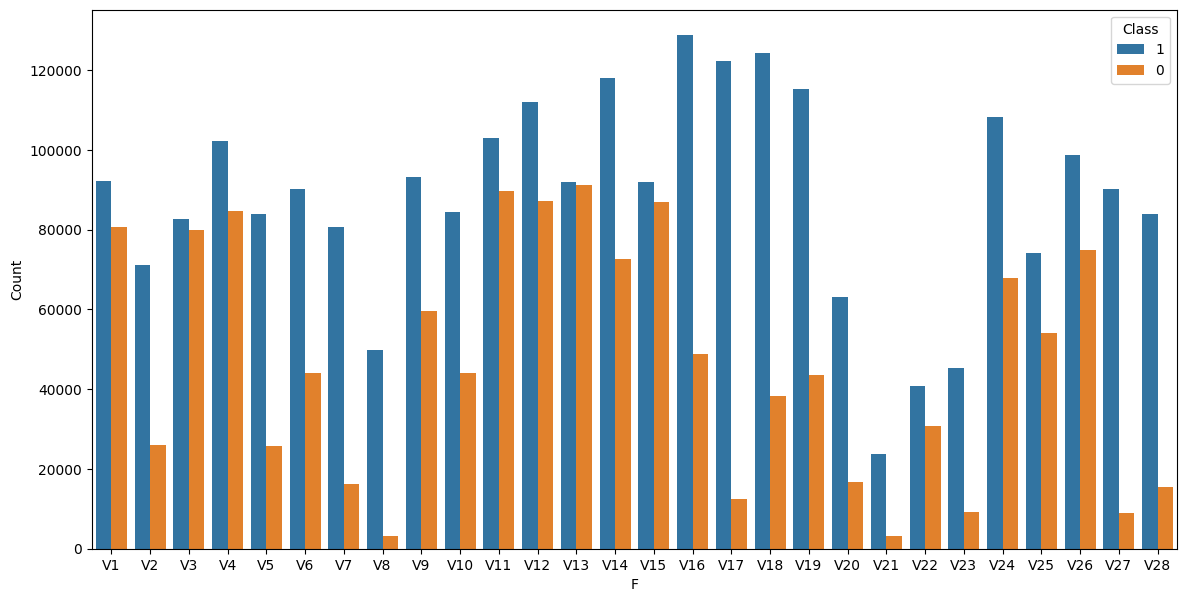

In [13]:
chart = sns.barplot(data=chart_data_pd, x='F', y='Count', hue='Class')
plt.show()

### Выводы
* Большая часть значений лежит между -1 и 1
* Есть большие выбросы (по значению), по количеству выбросов нужно уточнять, визуально невозможно сказать, т.к. данных много и то что мы видим выбросы, мы не знаем какую часть от выборки они составляют.

### Выборка 1000 записей, без каких либо манипуляций с данными

In [14]:
df_x = pd.DataFrame(data=df, columns=df.columns[:-1])
df_y = pd.DataFrame(data=df[df.columns[-1]])

df_train_x, df_test_x, df_train_y, df_test_y  = train_test_split(df_x, df_y, test_size=0.002)


df_1000 = pd.DataFrame(data=pd.concat([df_test_x, df_test_y], axis=1))
df_sample = pd.DataFrame(data=pd.concat([df_train_x, df_train_y], axis=1))

print(f"Test sample (no any changes) records: {df_1000.shape[0]}")
print(f"Main sample records: {df_sample.shape[0]}")

Test sample (no any changes) records: 1138
Main sample records: 567492


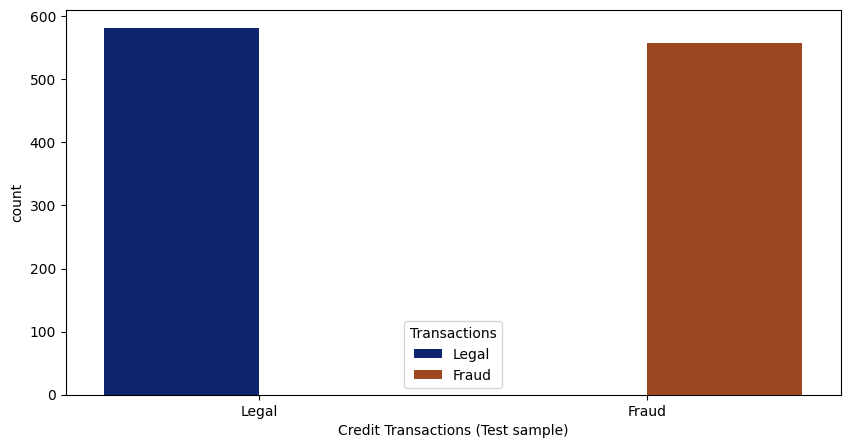

In [15]:
# Проверка на смещение данных
plt.figure(figsize=(10,5))
chart = sns.countplot(data=df_1000, x='Class', hue='Class', palette='dark')
chart.set(xlabel='Credit Transactions (Test sample)', xticks=[0,1], xticklabels=('Legal', 'Fraud'))
chart.legend(title='Transactions', labels=['Legal', 'Fraud'])
plt.show()

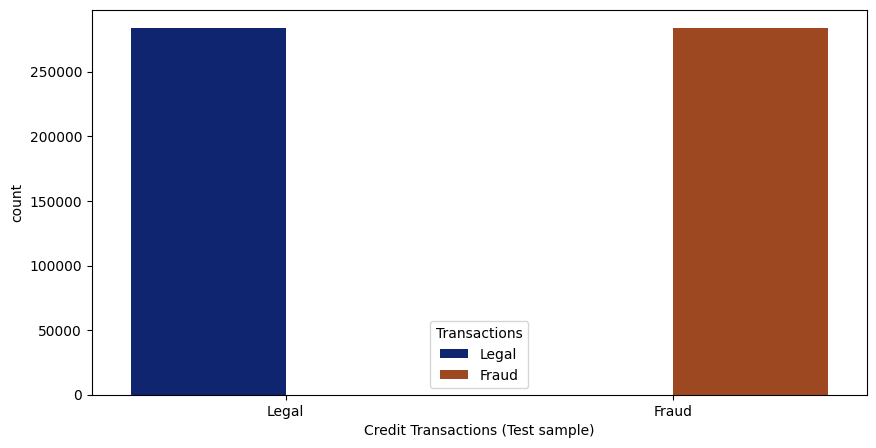

In [16]:
plt.figure(figsize=(10,5))
chart = sns.countplot(data=df_sample, x='Class', hue='Class', palette='dark')
chart.set(xlabel='Credit Transactions (Test sample)', xticks=[0,1], xticklabels=('Legal', 'Fraud'))
chart.legend(title='Transactions', labels=['Legal', 'Fraud'])
plt.show()

In [17]:
X = pd.DataFrame(data=df_sample, columns=df.columns[:-1])
y = df_sample["Class"].values

### Объяснение метрики

Я выбрал Precision, потому что нам важно не ошибиться (False Positive хуже чем False Negative)

### Логистическая регрессия

In [18]:
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg_scores = cross_val_score(logreg, X, y, cv=5)

In [19]:
logreg_scores

array([0.96514507, 0.96488075, 0.96325926, 0.96407866, 0.96513595])

In [20]:
logreg_scores_recall = cross_val_score(logreg, X, y, cv=5, scoring='recall')
logreg_scores_recall

array([0.9791373 , 0.97874965, 0.97841486, 0.98052898, 0.97878451])

In [21]:
logreg_scores_precision = cross_val_score(logreg, X, y, cv=5, scoring='precision')
logreg_scores_precision

array([0.95248543, 0.95233687, 0.94963401, 0.94929885, 0.95277873])

### XGBoost

In [22]:
xgboost = XGBClassifier(random_state=42, n_jobs=-1)
xgboost_scores_precision = cross_val_score(xgboost, X, y, cv=5, scoring='precision')
xgboost_scores_precision

array([1., 1., 1., 1., 1.])

### Random Forest

In [23]:
random_forest = RandomForestClassifier(max_depth=40, random_state=42)
random_forest_scores_precision = cross_val_score(random_forest, X, y, cv=5, scoring='precision')

In [24]:
random_forest_scores_precision

array([1., 1., 1., 1., 1.])

### KNN

In [25]:
knn = KNeighborsClassifier(n_neighbors=3)
knn_scores_precision = cross_val_score(knn, X, y, cv=5, scoring='precision')

In [26]:
knn_scores_precision

array([0.91398938, 0.91408703, 0.91150383, 0.91319929, 0.91284087])

### Стандартизация

In [27]:
scaler = StandardScaler()

In [28]:
pipeline = Pipeline([('transformer', scaler), ('estimator', logreg)])
logistic_scores_std = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
logistic_scores_std

array([0.95319791, 0.95293007, 0.95152243, 0.95324921, 0.95287617])

In [29]:
pipeline = Pipeline([('transformer', scaler), ('estimator', xgboost)])
xgboost_scores_std = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
xgboost_scores_std

array([1., 1., 1., 1., 1.])

In [30]:
pipeline = Pipeline([('transformer', scaler), ('estimator', random_forest)])
random_forest_scores_std = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
random_forest_scores_std

array([1., 1., 1., 1., 1.])

In [31]:
pipeline = Pipeline([('transformer', scaler), ('estimator', knn)])
knn_scores_std = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
knn_scores_std

array([1., 1., 1., 1., 1.])

### Подбор гиперпараметров
* Может есть смысл сначала на маленькой выборке (1000-10000 записей прогнать по бОльшей ренже параметров), а потом уже в окрестностях лучших параметров для 1000-10000 прогонять для всей выборки?

In [32]:
# Возьмем поменьше выборку, для поиска гиперпараметров (10000 записей)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.98)
df_train_x.shape

(11349, 29)

#### Grid Search

In [33]:
logreg_grid_params = { 
    'logistic__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
xgboost_grid_params = {
    'xgboost__max_depth': [3,6,9],
    'xgboost__base_score': [0.2, 0.4, 0.6, 0.8],
}
random_forest_grid_params = {
    'random_forest__n_estimators': range(50, 201, 50),
    'random_forest__max_depth': [1,10,20,30,40],
    'random_forest__min_samples_leaf': [1, 4],
}
knn_grid_params = {
    'knn__n_neighbors': [3,5,7],
    'knn__p': [1, 2], 
    'knn__leaf_size': range(10,41,10)
}

scaler = StandardScaler()

logistic = LogisticRegression(max_iter=1000)
xgboost = XGBClassifier(random_state=42, n_jobs=-1)
random_forest = RandomForestClassifier(max_depth=4, random_state=42)
knn = KNeighborsClassifier()

results = []

for fit_x, fit_y, name, model, params in [(X, y, 'logistic',logistic, logreg_grid_params), 
                            (X, y, 'xgboost', xgboost, xgboost_grid_params),
                            (df_train_x, df_train_y, 'random_forest', random_forest, random_forest_grid_params),
                            (df_train_x, df_train_y, 'knn', knn, knn_grid_params)]:

    # НУЖНО ЛИ ДОБАВЛЯТЬ СКАЛЕР В ПАЙПЛАЙН ИЛИ СРАЗУ НА ВСЮ ВЫБОРКУ? КАК ДЕЛАЮТ ОБЫЧНО?
    pipe = Pipeline(steps=[("scaler", scaler), (name, model)])
    grid = GridSearchCV(pipe, params, cv=5, scoring='precision', n_jobs=-1)
    grid.fit(fit_x, fit_y)
    results.append(f'{name}\nparams:{grid.best_params_}\nscore: {grid.best_score_}')

In [34]:
def show(results):
    for result in results:
        print(result)
show(results)

logistic
params:{'logistic__C': 1.0}
score: 0.9527551577287655
xgboost
params:{'xgboost__base_score': 0.2, 'xgboost__max_depth': 9}
score: 1.0
random_forest
params:{'random_forest__max_depth': 30, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 100}
score: 0.9793706541428552
knn
params:{'knn__leaf_size': 10, 'knn__n_neighbors': 3, 'knn__p': 1}
score: 0.9981991703934149


#### Bayes Search

In [35]:
logreg_grid_params = { 
    'logistic__C': Real(0.1, 1.0),
}
xgboost_grid_params = {
    'xgboost__max_depth': Integer(3,9),
    'xgboost__base_score': Real(0.1, 0.9),
}
random_forest_grid_params = {
    'random_forest__n_estimators': Integer(50, 200),
    'random_forest__max_depth': Categorical([10, 20, 30, 40]),
    'random_forest__min_samples_leaf': Integer(1, 4),
}
knn_grid_params = {
    'knn__n_neighbors': Integer(3,7),
    'knn__p': Integer(1, 2),
    'knn__leaf_size': Integer(10,40)
}

scaler = StandardScaler()

logistic = LogisticRegression(max_iter=1000)
xgboost = XGBClassifier(random_state=42, n_jobs=-1)
random_forest = RandomForestClassifier(max_depth=4, random_state=42)
knn = KNeighborsClassifier()

bayes_search_results = []

for name, model, params in [('logistic',logistic, logreg_grid_params), 
                            ('xgboost', xgboost, xgboost_grid_params),
                            ('random_forest', random_forest, random_forest_grid_params),
                            ('knn', knn, knn_grid_params)]:
    print(name)
    pipe = Pipeline(steps=[("scaler", scaler), (name, model)])
    grid = BayesSearchCV(pipe, params, cv=5, n_iter=50, scoring='precision', n_jobs=-1, verbose=1)
    grid.fit(df_train_x, df_train_y)
    bayes_search_results.append(f'{name}\nparams:{grid.best_params_}\nscore: {grid.best_score_}')

bayes_search_results

logistic
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, total

["logistic\nparams:OrderedDict([('logistic__C', 0.985712562225427)])\nscore: 0.95185635967496",
 "xgboost\nparams:OrderedDict([('xgboost__base_score', 0.9), ('xgboost__max_depth', 6)])\nscore: 0.9929618646661439",
 "random_forest\nparams:OrderedDict([('random_forest__max_depth', 40), ('random_forest__min_samples_leaf', 1), ('random_forest__n_estimators', 84)])\nscore: 0.9797062232364832",
 "knn\nparams:OrderedDict([('knn__leaf_size', 22), ('knn__n_neighbors', 4), ('knn__p', 1)])\nscore: 0.998543299303947"]

In [36]:
show(bayes_search_results)

logistic
params:OrderedDict([('logistic__C', 0.985712562225427)])
score: 0.95185635967496
xgboost
params:OrderedDict([('xgboost__base_score', 0.9), ('xgboost__max_depth', 6)])
score: 0.9929618646661439
random_forest
params:OrderedDict([('random_forest__max_depth', 40), ('random_forest__min_samples_leaf', 1), ('random_forest__n_estimators', 84)])
score: 0.9797062232364832
knn
params:OrderedDict([('knn__leaf_size', 22), ('knn__n_neighbors', 4), ('knn__p', 1)])
score: 0.998543299303947


#### Random Search

In [37]:
logreg_grid_params = { 
    'logistic__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}
xgboost_grid_params = {
    'xgboost__max_depth': [3,6,9],
    'xgboost__base_score': [0.2, 0.4, 0.6, 0.8],
}
random_forest_grid_params = {
    'random_forest__n_estimators': range(50, 201, 50),
    'random_forest__max_depth': [1,10,20,30,40],
    'random_forest__min_samples_leaf': [1, 4],
}
knn_grid_params = {
    'knn__n_neighbors': [3,5,7],
    'knn__p': [1, 2], 
    'knn__leaf_size': range(10,41,10)
}

scaler = StandardScaler()

logistic = LogisticRegression(max_iter=1000)
xgboost = XGBClassifier(random_state=42, n_jobs=-1)
random_forest = RandomForestClassifier(max_depth=4, random_state=42)
knn = KNeighborsClassifier()

random_search_results = []


for fit_x, fit_y, name, model, params in [(X, y, 'logistic',logistic, logreg_grid_params), 
                            (X, y, 'xgboost', xgboost, xgboost_grid_params),
                            (df_train_x, df_train_y, 'random_forest', random_forest, random_forest_grid_params),
                            (df_train_x, df_train_y, 'knn', knn, knn_grid_params)]:

    pipe = Pipeline(steps=[("scaler", scaler), (name, model)])
    grid = RandomizedSearchCV(pipe, params, cv=5, scoring='precision', n_jobs=-1, verbose=10)
    grid.fit(fit_x, fit_y)
    random_search_results.append(f'{name}\nparams:{grid.best_params_}\nscore: {grid.best_score_}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [38]:
show(random_search_results)

logistic
params:{'logistic__C': 1.0}
score: 0.9527551577287655
xgboost
params:{'xgboost__max_depth': 9, 'xgboost__base_score': 0.4}
score: 1.0
random_forest
params:{'random_forest__n_estimators': 100, 'random_forest__min_samples_leaf': 1, 'random_forest__max_depth': 30}
score: 0.9793706541428552
knn
params:{'knn__p': 1, 'knn__n_neighbors': 3, 'knn__leaf_size': 10}
score: 0.9981991703934149


## Выводы по гиперпараметрам
Лучше всего себя показала модель XGBoost. 
## Feature Importance (Use Sharp)

In [39]:
shap.initjs()
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(X, y, test_size=0.3)

 52%|==========          | 88867/170248 [05:00<04:34]       

[CV 2/5; 1/10] START logistic__C=0.1............................................
[CV 2/5; 1/10] END .............logistic__C=0.1;, score=0.953 total time=   4.0s
[CV 2/5; 5/10] START logistic__C=0.5............................................
[CV 2/5; 5/10] END .............logistic__C=0.5;, score=0.953 total time=   4.1s
[CV 1/5; 8/10] START logistic__C=0.8............................................
[CV 1/5; 8/10] END .............logistic__C=0.8;, score=0.953 total time=   4.1s
[CV 3/5; 2/10] START xgboost__base_score=0.8, xgboost__max_depth=6..............
[CV 3/5; 2/10] END xgboost__base_score=0.8, xgboost__max_depth=6;, score=1.000 total time=  13.6s
[CV 3/5; 5/10] START xgboost__base_score=0.4, xgboost__max_depth=6..............
[CV 3/5; 5/10] END xgboost__base_score=0.4, xgboost__max_depth=6;, score=1.000 total time=  12.5s
[CV 5/5; 8/10] START xgboost__base_score=0.8, xgboost__max_depth=9..............
[CV 5/5; 8/10] END xgboost__base_score=0.8, xgboost__max_depth=9;, score=1.

 52%|==========          | 89339/170248 [05:02<04:33]       

[CV 3/5; 1/10] START logistic__C=0.1............................................
[CV 3/5; 1/10] END .............logistic__C=0.1;, score=0.951 total time=   4.1s
[CV 3/5; 5/10] START logistic__C=0.5............................................
[CV 3/5; 5/10] END .............logistic__C=0.5;, score=0.951 total time=   4.0s
[CV 2/5; 8/10] START logistic__C=0.8............................................
[CV 2/5; 8/10] END .............logistic__C=0.8;, score=0.953 total time=   4.0s
[CV 1/5; 1/10] START xgboost__base_score=0.4, xgboost__max_depth=9..............
[CV 1/5; 1/10] END xgboost__base_score=0.4, xgboost__max_depth=9;, score=1.000 total time=  16.0s
[CV 4/5; 6/10] START xgboost__base_score=0.2, xgboost__max_depth=3..............
[CV 4/5; 6/10] END xgboost__base_score=0.2, xgboost__max_depth=3;, score=0.997 total time=   9.5s
[CV 2/5; 8/10] START xgboost__base_score=0.8, xgboost__max_depth=9..............
[CV 2/5; 8/10] END xgboost__base_score=0.8, xgboost__max_depth=9;, score=1.

 53%|===========         | 89578/170248 [05:03<04:32]       

[CV 5/5; 2/10] START logistic__C=0.2............................................
[CV 5/5; 2/10] END .............logistic__C=0.2;, score=0.953 total time=   4.4s
[CV 2/5; 7/10] START logistic__C=0.7............................................
[CV 2/5; 7/10] END .............logistic__C=0.7;, score=0.953 total time=   4.1s
[CV 2/5; 10/10] START logistic__C=1.0...........................................
[CV 2/5; 10/10] END ............logistic__C=1.0;, score=0.953 total time=   3.8s
[CV 1/5; 3/10] START xgboost__base_score=0.4, xgboost__max_depth=3..............
[CV 1/5; 3/10] END xgboost__base_score=0.4, xgboost__max_depth=3;, score=0.998 total time=  15.8s
[CV 3/5; 6/10] START xgboost__base_score=0.2, xgboost__max_depth=3..............
[CV 3/5; 6/10] END xgboost__base_score=0.2, xgboost__max_depth=3;, score=0.998 total time=  16.2s
[CV 4/5; 9/10] START xgboost__base_score=0.6, xgboost__max_depth=6..............
[CV 4/5; 9/10] END xgboost__base_score=0.6, xgboost__max_depth=6;, score=1.

 53%|===========         | 91004/170248 [05:09<04:29]       

000 total time=  18.2s
[CV 5/5; 3/10] START random_forest__max_depth=20, random_forest__min_samples_leaf=4, random_forest__n_estimators=50
[CV 5/5; 3/10] END random_forest__max_depth=20, random_forest__min_samples_leaf=4, random_forest__n_estimators=50;, score=0.962 total time=   2.2s
[CV 2/5; 6/10] START random_forest__max_depth=1, random_forest__min_samples_leaf=1, random_forest__n_estimators=100
[CV 2/5; 6/10] END random_forest__max_depth=1, random_forest__min_samples_leaf=1, random_forest__n_estimators=100;, score=0.882 total time=   0.8s
[CV 3/5; 7/10] START random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=200
[CV 3/5; 7/10] END random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=200;, score=0.984 total time=   9.1s
[CV 2/5; 2/10] START knn__leaf_size=10, knn__n_neighbors=5, knn__p=1............
[CV 2/5; 2/10] END knn__leaf_size=10, knn__n_neighbors=5, knn__p=1;, score=0.998 total time=   0.5s
[CV 1

 54%|===========         | 91477/170248 [05:11<04:27]       

th=1, random_forest__min_samples_leaf=4, random_forest__n_estimators=50;, score=0.877 total time=   0.4s
[CV 3/5; 4/10] START random_forest__max_depth=10, random_forest__min_samples_leaf=4, random_forest__n_estimators=50
[CV 3/5; 4/10] END random_forest__max_depth=10, random_forest__min_samples_leaf=4, random_forest__n_estimators=50;, score=0.958 total time=   1.9s
[CV 3/5; 6/10] START random_forest__max_depth=1, random_forest__min_samples_leaf=1, random_forest__n_estimators=100
[CV 3/5; 6/10] END random_forest__max_depth=1, random_forest__min_samples_leaf=1, random_forest__n_estimators=100;, score=0.875 total time=   0.8s
[CV 4/5; 7/10] START random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=200
[CV 4/5; 7/10] END random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=200;, score=0.977 total time=   9.0s
[CV 1/5; 2/10] START knn__leaf_size=10, knn__n_neighbors=5, knn__p=1............
[CV 1/5; 2/10] END knn_

 54%|===========         | 92184/170248 [05:14<04:25]       

000 total time=  15.5s
[CV 1/5; 1/10] START random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__n_estimators=200
[CV 1/5; 1/10] END random_forest__max_depth=20, random_forest__min_samples_leaf=1, random_forest__n_estimators=200;, score=0.979 total time=   8.8s
[CV 2/5; 9/10] START random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=100
[CV 2/5; 9/10] END random_forest__max_depth=30, random_forest__min_samples_leaf=1, random_forest__n_estimators=100;, score=0.982 total time=   4.0s
[CV 4/5; 2/10] START knn__leaf_size=10, knn__n_neighbors=5, knn__p=1............
[CV 4/5; 2/10] END knn__leaf_size=10, knn__n_neighbors=5, knn__p=1;, score=0.997 total time=   0.8s
[CV 2/5; 6/10] START knn__leaf_size=20, knn__n_neighbors=7, knn__p=2............
[CV 2/5; 6/10] END knn__leaf_size=20, knn__n_neighbors=7, knn__p=2;, score=0.989 total time=   0.3s
[CV 2/5; 8/10] START knn__leaf_size=40, knn__n_neighbors=3, knn__p=1............
[CV 

 55%|===========         | 92890/170248 [05:17<04:23]       

[CV 4/5; 3/10] START logistic__C=0.3............................................
[CV 4/5; 3/10] END .............logistic__C=0.3;, score=0.953 total time=   4.1s
[CV 4/5; 6/10] START logistic__C=0.6............................................
[CV 4/5; 6/10] END .............logistic__C=0.6;, score=0.953 total time=   4.0s
[CV 1/5; 9/10] START logistic__C=0.9............................................
[CV 1/5; 9/10] END .............logistic__C=0.9;, score=0.953 total time=   4.1s
[CV 4/5; 2/10] START xgboost__base_score=0.8, xgboost__max_depth=6..............
[CV 4/5; 2/10] END xgboost__base_score=0.8, xgboost__max_depth=6;, score=1.000 total time=  13.1s
[CV 5/5; 4/10] START xgboost__base_score=0.2, xgboost__max_depth=9..............
[CV 5/5; 4/10] END xgboost__base_score=0.2, xgboost__max_depth=9;, score=1.000 total time=  15.7s
[CV 3/5; 9/10] START xgboost__base_score=0.6, xgboost__max_depth=6..............
[CV 3/5; 9/10] END xgboost__base_score=0.6, xgboost__max_depth=6;, score=1.

 55%|===========         | 93360/170248 [05:19<04:22]       

[CV 4/5; 1/10] START logistic__C=0.1............................................
[CV 4/5; 1/10] END .............logistic__C=0.1;, score=0.953 total time=   3.8s
[CV 2/5; 4/10] START logistic__C=0.4............................................
[CV 2/5; 4/10] END .............logistic__C=0.4;, score=0.953 total time=   4.1s
[CV 3/5; 7/10] START logistic__C=0.7............................................
[CV 3/5; 7/10] END .............logistic__C=0.7;, score=0.951 total time=   4.2s
[CV 4/5; 1/10] START xgboost__base_score=0.4, xgboost__max_depth=9..............
[CV 4/5; 1/10] END xgboost__base_score=0.4, xgboost__max_depth=9;, score=1.000 total time=  20.6s
[CV 1/5; 7/10] START xgboost__base_score=0.6, xgboost__max_depth=9..............
[CV 1/5; 7/10] END xgboost__base_score=0.6, xgboost__max_depth=9;, score=1.000 total time=  15.6s
[CV 1/5; 10/10] START xgboost__base_score=0.6, xgboost__max_depth=3.............
[CV 1/5; 10/10] END xgboost__base_score=0.6, xgboost__max_depth=3;, score=0

100%|===================| 170032/170248 [09:45<00:00]        

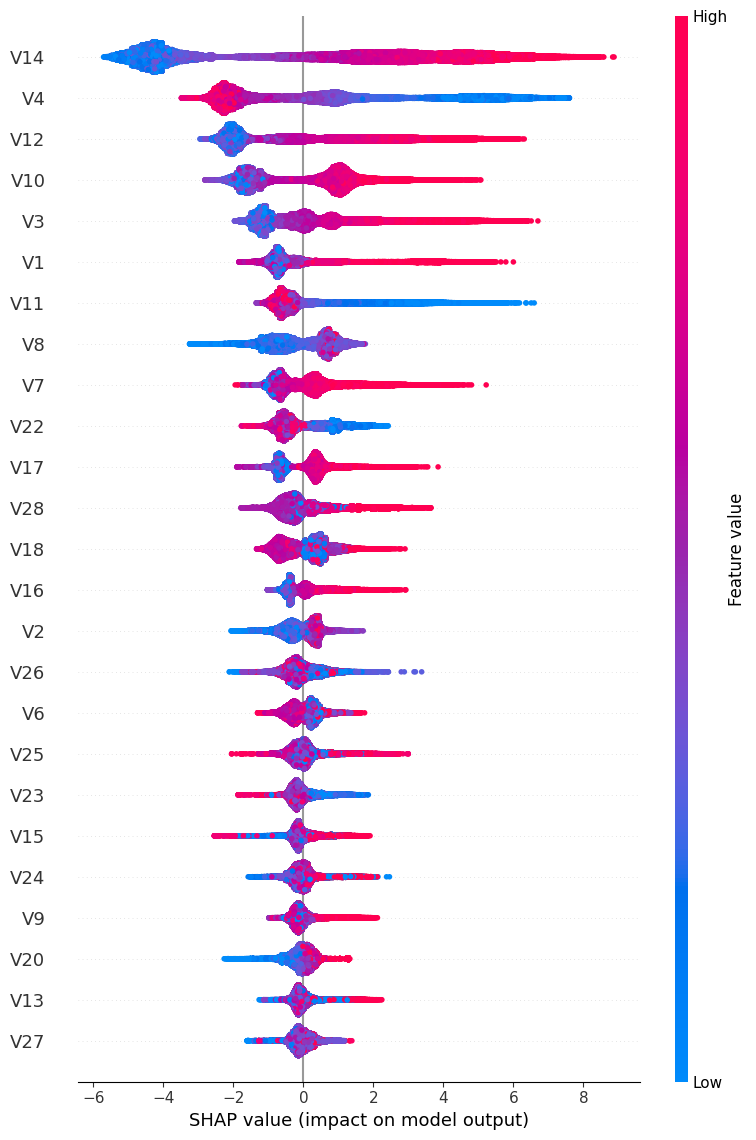

In [40]:
xgboost_model = XGBClassifier(max_depth=6, base_score=0.2, random_state=42, n_jobs=-1)
xgboost_model.fit(df_train_x, df_train_y)
explainer = shap.Explainer(xgboost_model, df_test_x)
xgboost_shap_values = explainer(df_test_x)

shap.summary_plot(xgboost_shap_values, df_test_x, max_display=25, auto_size_plot=True)

In [91]:
df_test_x["Class"] = df_test_y

<Figure size 2000x2500 with 0 Axes>

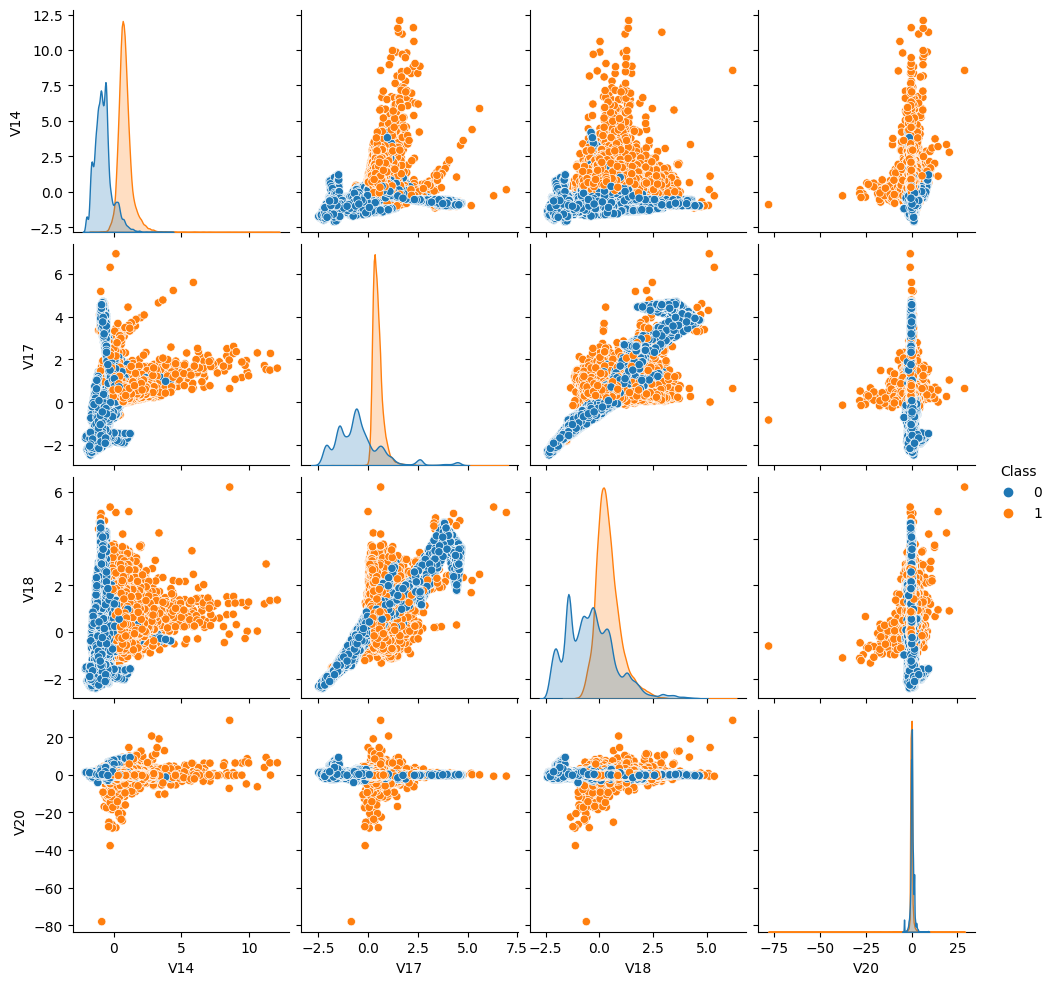

In [131]:
plt.figure(figsize=(20,25))
sns.pairplot(data=df_test_x[["V14","V17","V18","V20","Class"]], hue='Class')
plt.show()

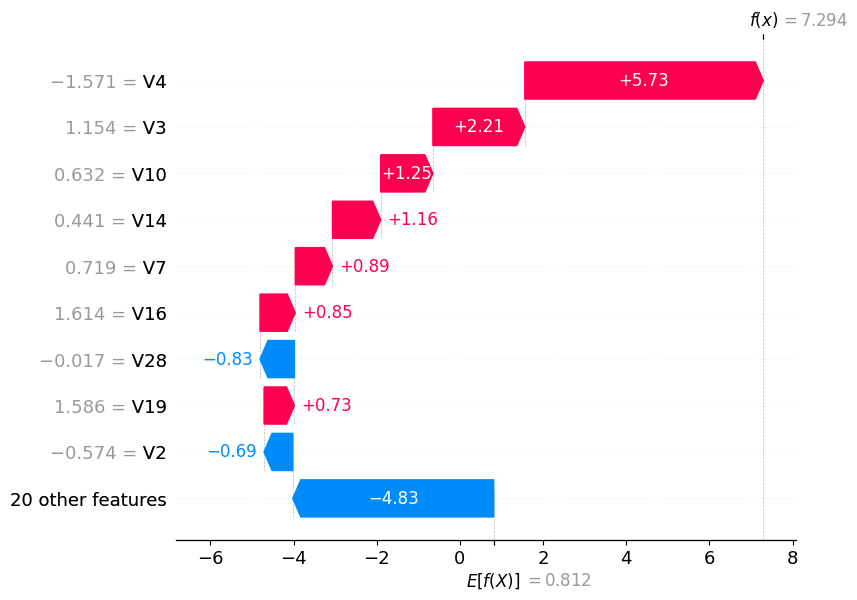

In [41]:
shap.plots.waterfall(xgboost_shap_values[0])

In [42]:
shap.plots.force(xgboost_shap_values[0])

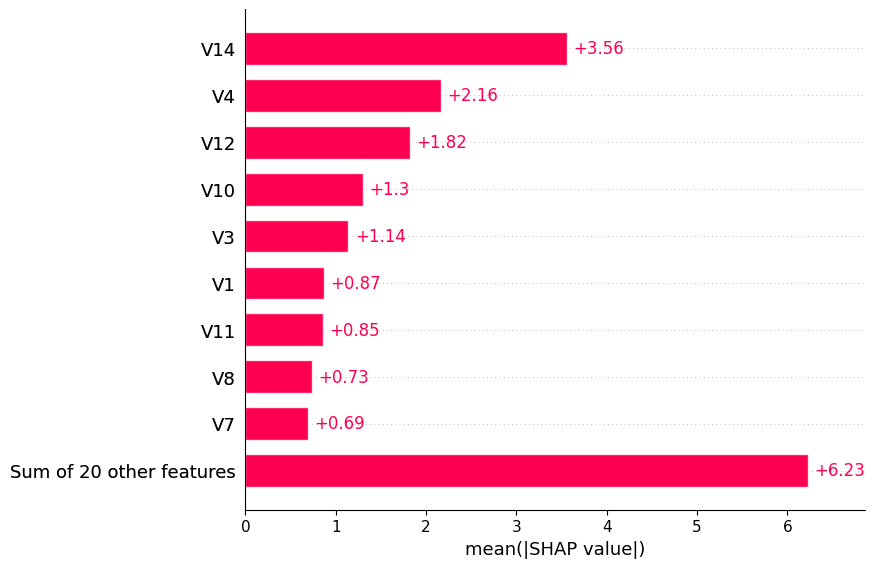

In [43]:
shap.plots.bar(xgboost_shap_values)

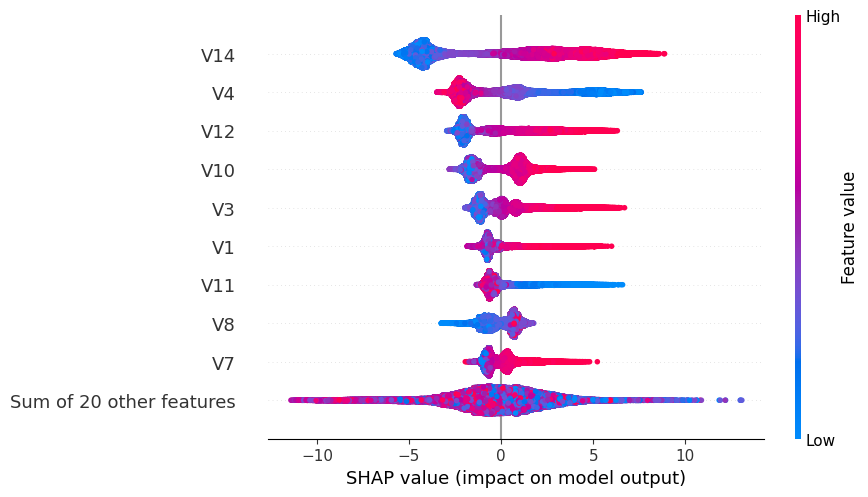

In [44]:
shap.plots.beeswarm(xgboost_shap_values)

In [45]:
shap.plots.force(xgboost_shap_values[0])

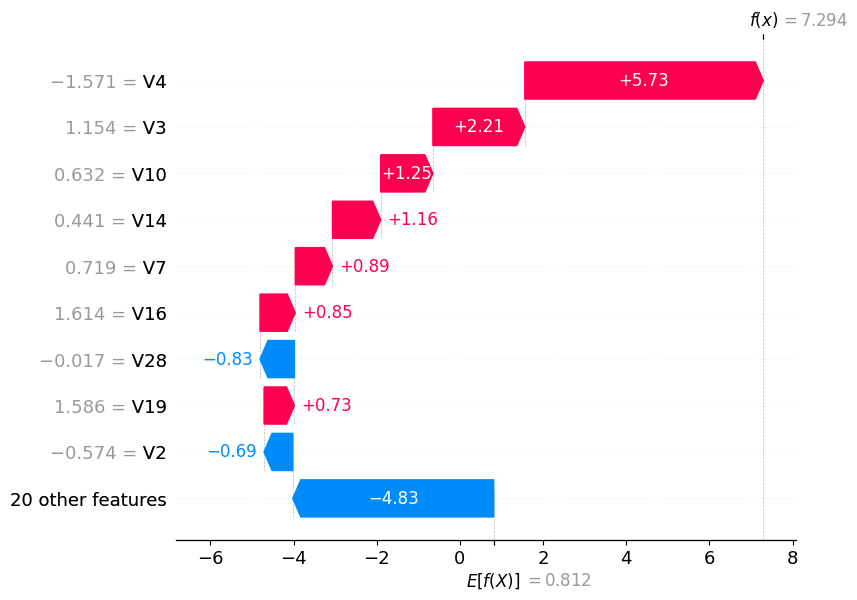

In [46]:
shap.plots.waterfall(xgboost_shap_values[0])

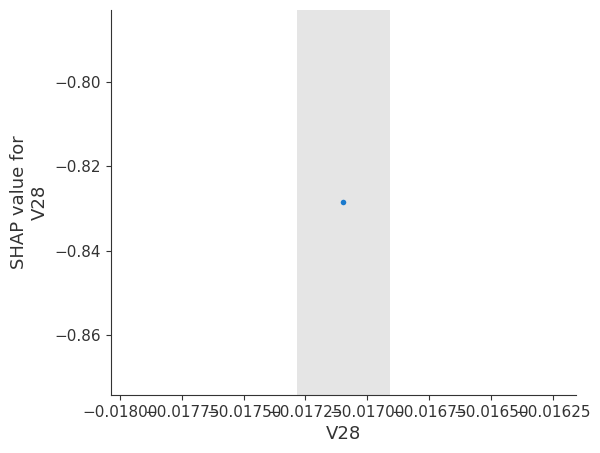

In [47]:
shap.plots.scatter(xgboost_shap_values[:1,"V28"])

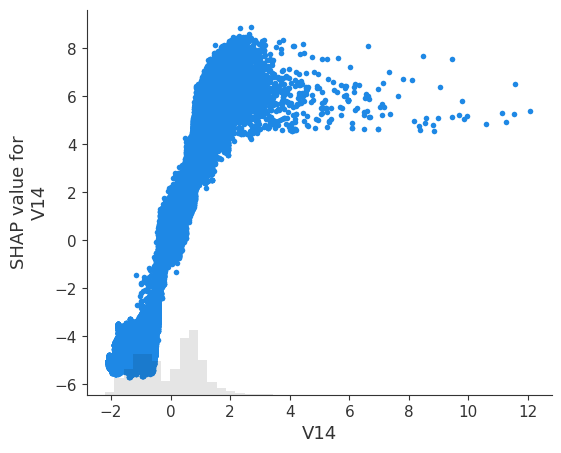

In [48]:
shap.plots.scatter(xgboost_shap_values[:,"V14"])

/home/ilya/workspace/jupyter/venv_jupyter_310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


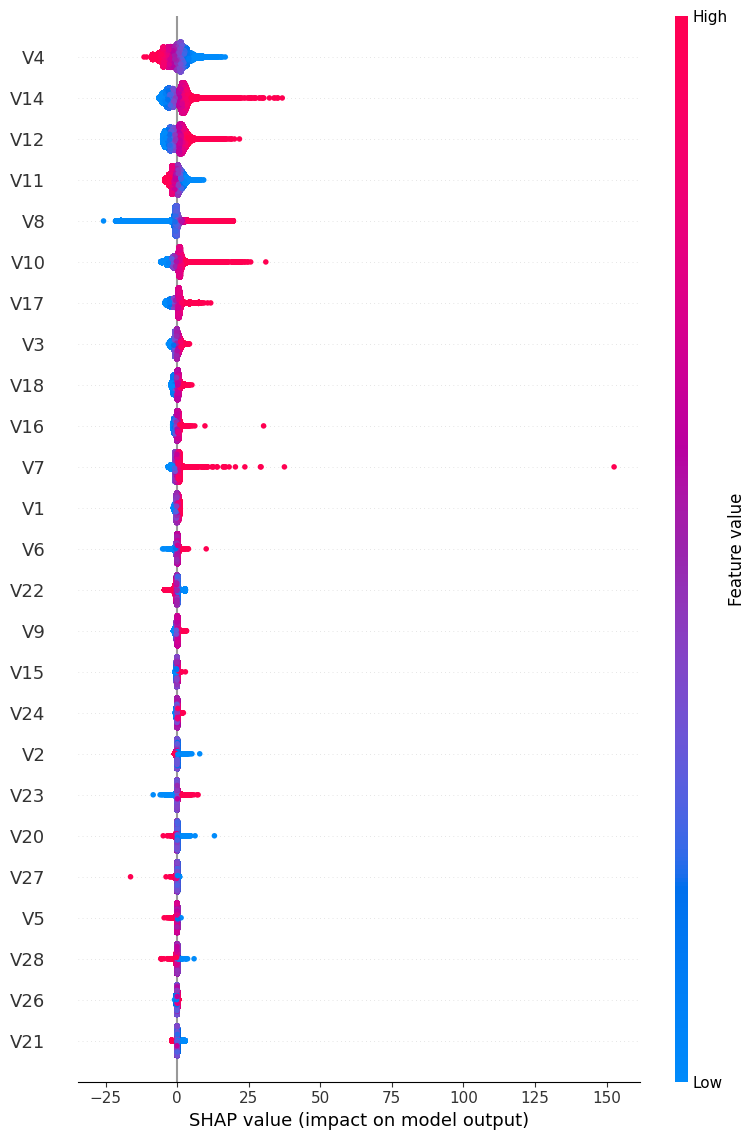

In [49]:
logistic_model = LogisticRegression(max_iter=1000, C=1.0, random_state=42, n_jobs=-1)
logistic_model.fit(df_train_x, df_train_y)
explainer = shap.Explainer(logistic_model, df_train_x)
logistic_shap_values = explainer(df_test_x)
shap.summary_plot(logistic_shap_values, df_test_x, max_display=25, auto_size_plot=True)

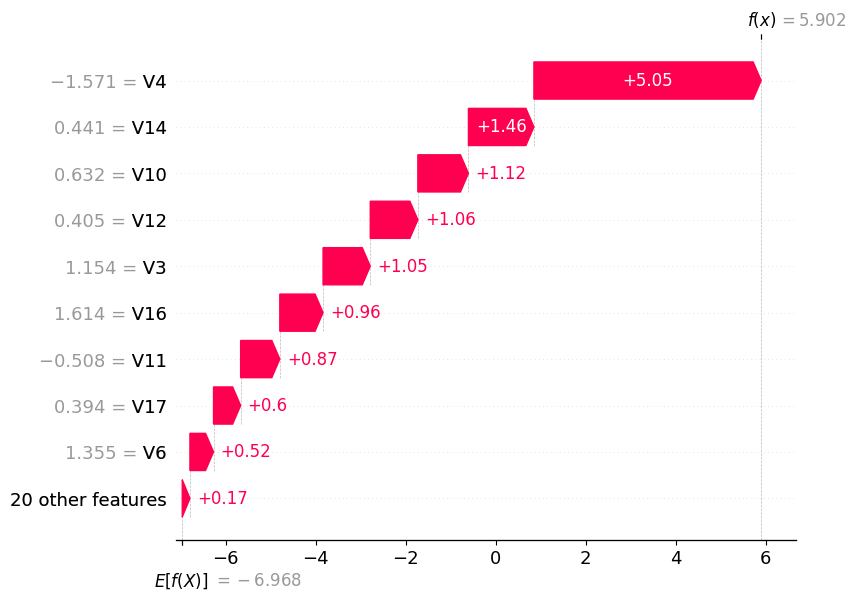

In [50]:
shap.plots.waterfall(logistic_shap_values[0])

In [51]:
shap.plots.force(logistic_shap_values[0])

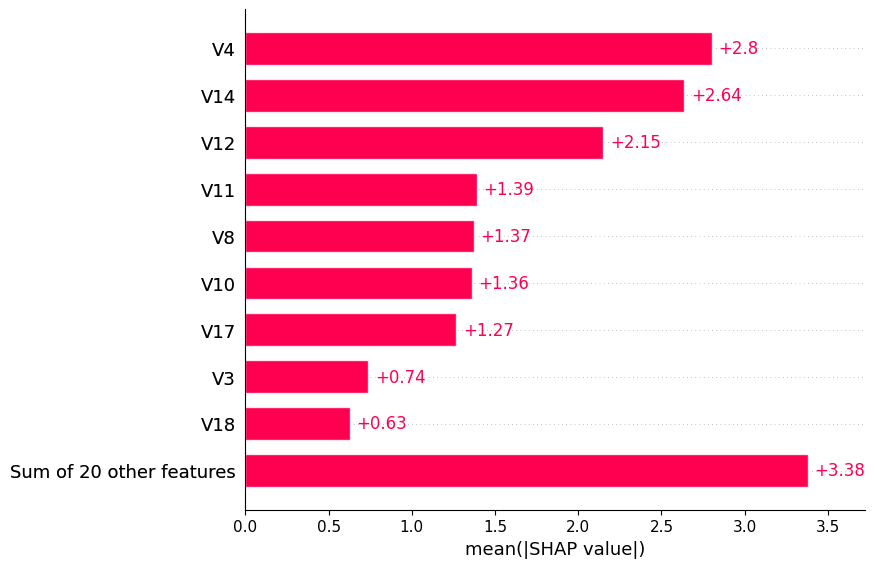

In [52]:
shap.plots.bar(logistic_shap_values)

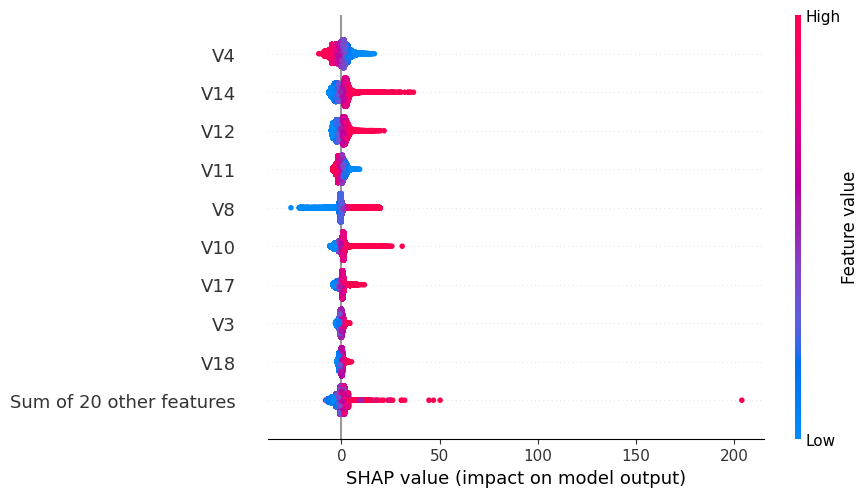

In [53]:
shap.plots.beeswarm(logistic_shap_values)

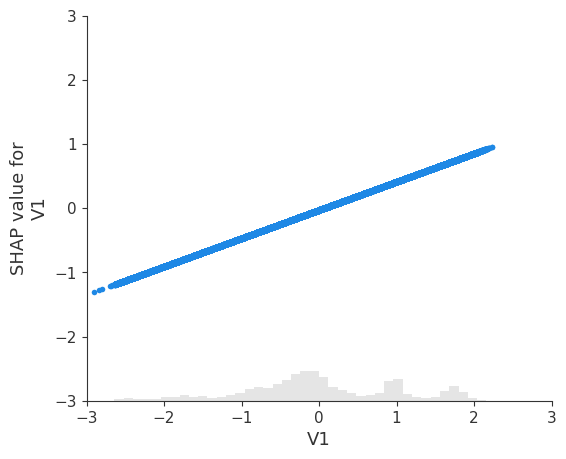

In [54]:
shap.plots.scatter(logistic_shap_values[:,"V1"], ymin=-3, ymax=3, xmin=-3, xmax=3)

In [55]:
precision_score(xgboost_model.predict(df_test_x), df_test_y)

0.9994494553121706

In [56]:
df_train_x_fi = pd.DataFrame(data=df_train_x, columns=['V3','V4','V10','V11','V12','V14'])
df_test_x_fi = pd.DataFrame(data=df_test_x, columns=['V3','V4','V10','V11','V12','V14'])

In [57]:
xgboost_model = XGBClassifier(max_depth=6, base_score=0.2, random_state=42, n_jobs=-1)
xgboost_model.fit(df_train_x_fi, df_train_y)

XGBClassifier(base_score=0.2, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [58]:
precision_score(xgboost_model.predict(df_test_x_fi), df_test_y)

0.9916598336652219

#### Отобрав 6 признаков, наша предсказательная способность упала на 0.009, но это было без стандартизации

In [59]:
pipeline = Pipeline([('transformer', scaler), ('estimator', xgboost_model)])
xgboost_scores_std = cross_val_score(pipeline, X, y, cv=5, scoring='precision')
xgboost_scores_std

array([1.        , 1.        , 0.99998237, 1.        , 1.        ])

In [60]:
xgboost_scores_pred = cross_val_predict(pipeline, df_test_x_fi, df_test_y, cv=5)
precision_score(xgboost_scores_pred, df_test_y)

0.989844207567061

In [61]:
xgboost_model = XGBClassifier(max_depth=6, base_score=0.2, random_state=42, n_jobs=-1)
xgboost_model.fit(df_train_x_fi,df_train_y)

XGBClassifier(base_score=0.2, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

### Проверка на 1000 записях, которые не участвовали в обучении

In [62]:
df_x = pd.DataFrame(data=df_1000, columns=['V3','V4','V10','V11','V12','V14'])
df_y = pd.DataFrame(data=df_1000[df_1000.columns[-1]])

pred = xgboost_model.predict(df_x)
precision_score(df_y, pred)



0.9945750452079566

In [63]:
confusion_matrix(df_y,pred)

array([[578,   3],
       [  7, 550]])

In [64]:
# на случай важных переговоров

xgboost_model = XGBClassifier(scale_pos_weight=0.5, max_depth=6, base_score=0.2, random_state=42, n_jobs=-1)

df_train_x_fi_ = pd.DataFrame(data=df_train_x, columns=['V2','V13','V24'])
xgboost_model.fit(df_train_x_fi_,df_train_y)

df_x_ = pd.DataFrame(data=df_1000, columns=['V2','V13','V24'])

pred = xgboost_model.predict(df_x_)
precision_score(df_y, pred)

0.906187624750499

In [65]:
confusion_matrix(df_y,pred)

array([[534,  47],
       [103, 454]])